<a href="https://colab.research.google.com/github/Ayanlola2002/GIS/blob/main/Population_Analysis_Folium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#!pip install rasterio
#!pip install geopandas

In [48]:
# Import required packages
# --------------------
#import wget
import rasterio
from rasterio import mask

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import geopandas as gpd
import pandas as pd

import folium



In [49]:
# you 1st need to right click on the shared folder and select 'Add to my Drive'
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [50]:
# Read raster/tif file
# --------------------
uga_tif = '/content/drive/MyDrive/Paper_project Articles/GIS/Population_grided/nga_ppp_2019_1km_Aggregated_UNadj.tif'
raster_uga = rasterio.open(uga_tif)
pop_uga_data = raster_uga.read(1)



In [51]:
# A crude way to count the population size represented in the image
pop_uga_count = pop_uga_data[pop_uga_data > 0].sum()

In [52]:
## Plot raster/tif image
# --------------------
def plot_raster(rast_data, title='', figsize=(10,10)):
  """
  Plots population count in log scale(+1)
  """
  plt.figure(figsize = figsize)
  im1 = plt.imshow(np.log1p(rast_data),) # vmin=0, vmax=2.1)

  plt.title("{}".format(title), fontdict = {'fontsize': 20})  
  plt.axis('off')
  plt.colorbar(im1, fraction=0.03)


  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  


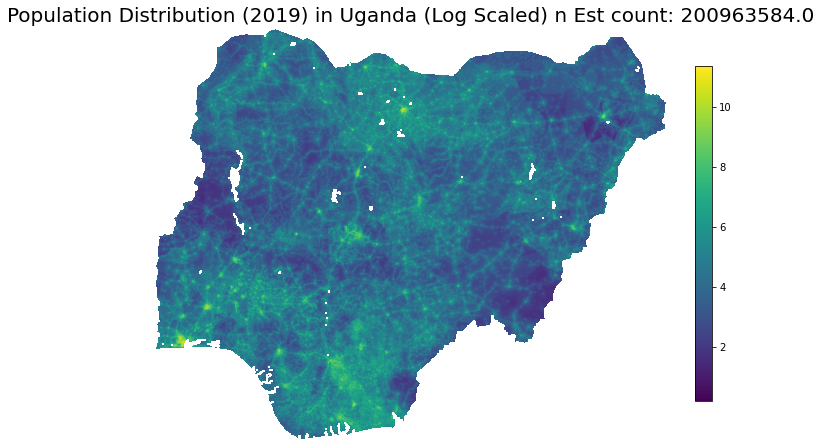

In [53]:
title = 'Population Distribution (2019) in Uganda (Log Scaled) n Est count: {}'.format(pop_uga_count)
plot_raster(pop_uga_data, title)

Text(0.5, 1.0, 'Uganda: level 2 regions')

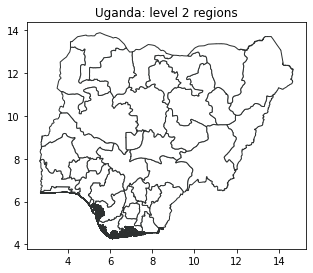

In [54]:
# the shape files for Uganda were downloaded here:

# https://gadm.org/

uga_gdf = gpd.GeoDataFrame.from_file("/content/drive/MyDrive/Paper_project Articles/GIS/Population_grided/STATES_LGAs_and_WARDS.zip (Unzipped Files)/adm1_STATES/gadm40_NGA_1.shp")


# plot the shapefile
plt.rcParams['figure.figsize'] = 5,5
uga_gdf.plot(color="white", edgecolor="#2e3131")
plt.title('Uganda: level 2 regions')

In [55]:
uga_gdf.head(3) #check the first few rows of the shapefile dataframe

,ID_0,COUNTRY,ID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,NGA,Nigeria,NGA.1_1,Abia,None,None,State,State,None,NG.AB,None,"POLYGON ((7.46283 4.98177, 7.46261 4.96793, 7...."
1,NGA,Nigeria,NGA.2_1,Adamawa,None,None,State,State,None,NG.AD,None,"POLYGON ((12.25072 8.17262, 12.24873 8.17020, ..."
2,NGA,Nigeria,NGA.3_1,Akwa Ibom,None,None,State,State,None,NG.AK,None,"MULTIPOLYGON (((8.31958 4.55764, 8.31958 4.557..."


In [56]:
uga_gdf.crs   #to see the CRS format of the file

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [57]:
# using mask.mask function from Rasterio to define the region of interest
gtraster, bound = mask.mask(raster_uga, uga_gdf[uga_gdf.NAME_1 == "Abia"].geometry, crop=True)

gtraster[0][gtraster[0]>0].sum()

3898743.2

In [61]:
# Estimate the population size per defined district for each year (from the .tif image available for each year)
# --------------------
for year in range(2019,2021):
 # Read raster/tif file
  raster_uga='/content/drive/MyDrive/Paper_project Articles/GIS/Population_grided/nga_ppp_{}_1km_Aggregated_UNadj.tif'.format(year) 
  pop_raster_uga = rasterio.open(raster_uga)   
  pop_uga_data = pop_raster_uga.read(1)
  _results = []
  # loop through each defined district contained in the shapefile and use it as the mask to extract values
  for i in uga_gdf['NAME_1']:
    roi = uga_gdf[uga_gdf.NAME_1 == i]

    # using the mask.mask module from Rasterio to specify the ROI
    gtraster, bound = mask.mask(pop_raster_uga, roi["geometry"], crop=True) 
        
    # values greater than 0 represent the estimated population count for that pixel
    _results.append(gtraster[0][gtraster[0]>0].sum())
  # save the estimated counts for each year in a new column
  uga_gdf[str(year)] = _results

# also, compute the percentage change in estimated counts across years
uga_gdf['growth_rate'] = uga_gdf[['2019', '2020']].pct_change(axis=1)['2020']*100
